In [4]:
import numpy as np, pandas as pd, geopandas as gpd, sklearn.metrics as metrics
import geemap, ee , rasterio, sankee, warnings, pickle
from matplotlib.lines import Line2D
from rasterio import features
from geopandas import GeoDataFrame
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from rasterio.mask import mask
from osgeo import gdal, osr, gdalconst
import os, glob, subprocess, json, fiona
import numpy.ma as ma
import rasterio, pickle
import matplotlib as mpl
import matplotlib.pyplot as plt, plotly.express as px
from sklearn import ensemble
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from matplotlib_scalebar.scalebar import ScaleBar
from scipy import stats
import seaborn as sns
import statsmodels
import glob
from glob import glob
import rasterio.plot as rplot
from scipy.cluster.hierarchy import dendrogram, linkage
from shapely.geometry import Polygon, Point, box
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from rasterio.plot import show
import rioxarray as rxr
from rio_cogeo.profiles import cog_profiles
from rasterio.merge import merge
from pyproj import Transformer
from sklearn.metrics import silhouette_samples, silhouette_score, ConfusionMatrixDisplay
from rasterstats import zonal_stats
from geocube.api.core import make_geocube
from glob import glob
from sklearn.cluster import KMeans, MiniBatchKMeans
warnings.filterwarnings('ignore')

In [3]:
#ee.Authenticate()

Enter verification code:  4/1AWgavdfLy-7aL_zL0Ln-ykgHx0BtfE_9-_5mAn1ry2t5QG7VkSWPsm5LzgE



Successfully saved authorization token.


In [5]:
ee.Initialize()

In [8]:
######################## subset L8 collection   ########################################
##################################################################################
def getFactorImg(factorNames, image):
    factorList = image.toDictionary().select(factorNames).values()
    return ee.Image.constant(factorList)

######################## pandas normalise   ########################################
##################################################################################
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

######################## L8 cloud mask   ########################################
##################################################################################
def getQABits(image, start, end, mask):
    pattern = 0
    for i in range(start,end-1):
        pattern += 2**i
    return image.select([0], [mask]).bitwiseAnd(pattern).rightShift(start)


def maskQuality(image):
    QA = image.select('QA_PIXEL')
    shadowMask = getQABits(QA,3,3,'cloud_shadow')
    cloudMask = getQABits(QA,5,5,'cloud')
    cirrusMask = getQABits(QA,9,9,'cirrus_detected')
    scaleImg = getFactorImg(['REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10'], image)
    offsetImg = getFactorImg(['REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10'], image)
    scaled = image.select('SR_B.|ST_B10').multiply(scaleImg).add(offsetImg)
    
    return (image.addBands(scaled, None, True)
            .updateMask(cirrusMask)
            # .updateMask(cloudMask)
            # .updateMask(shadowMask)
            )



def prepSrL8(image):
    dilateMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 0)).eq(0)
    cirrusMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    cloudMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 3)).eq(0)
    shadowMask =  image.select('QA_PIXEL').bitwiseAnd(int('11111', 4)).eq(0)
    snowMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 5)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    scaleImg = getFactorImg(['REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10'], image)
    offsetImg = getFactorImg(['REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10'], image)
    scaled = image.select('SR_B.|ST_B10').multiply(scaleImg).add(offsetImg)

    return (image.addBands(scaled, None, True)
                 .updateMask(cirrusMask)
                 # .updateMask(dilateMask)
                 # .updateMask(cloudMask)
                 # .updateMask(shadowMask)
                 # .updateMask(snowMask)
                 #.updateMask(saturationMask)
           )

######################## L8 scale factors   ####################################
##################################################################################
def apply_scale_factors(image):
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)

######################## convert L8 to SST   ####################################
##################################################################################
def sst(img):
    thermalBands = img.select('ST_TRAD')
    ln = k2_im.divide((k1_im.divide(thermalBands).add(1).log())).multiply(0.001).clip(site).rename("SST")
    #.convolve(kern)
    return img.addBands(ln)

######################## scale image   ####################################
##################################################################################
def scale(image):
    return ee.Image(image).multiply(0.001)

def addNDAVI(image):
    ndvi = image.normalizedDifference(['SR_B1', 'SR_B5']).rename('NDAVI')
    return image.addBands(ndvi)

def addNDWI(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B6']).rename('NDWI')
    return image.addBands(ndvi)


# Function to add raster to map
def addras(Map, layer, mi, ma, name):
    Map.addLayer(layer,
                 {'bands': ['SR_B4', 'SR_B3', 'SR_B2'],'max': ma, 'min' : mi},
                 name=name)
    
# Function to add raster to map
def addl5(Map, layer, mi, ma, name):
    Map.addLayer(layer,
                 {'bands': ['SR_B3', 'SR_B2', 'SR_B1'],'max': ma, 'min' : mi},
                 name=name)
    
def fmask(image):
    # see https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qaMask = image.select("QA_PIXEL").bitwiseAnd(int("11111", 2)).eq(0)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select("SR_B.").multiply(0.0000275).add(-0.2)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True).updateMask(qaMask)

# def addkNDAVI(image):
#     #Compute D2 a rename it to d2
#     var D2 = nir.subtract(red).pow(2)
#     .select([0],['d2']);
#     // Gamma, defined as 1/sigmaˆ2
#     var gamma = ee.Number(4e6).multiply(-2.0);
#     // Compute kernel (k) and KNDVI
#     var k = D2.divide(gamma).exp();
#     var kndvi = ee.Image.constant(1)
#     .subtract(k).divide(
#     ee.Image.constant(1).add(k))
#     .select([0],['knd']);
#     return image.addBands(kndvi);


def landsat5_to_landsat8(landsat5_img):
    #, landsat8_img
    """
    Corrects a Landsat 5 image to Landsat 8 by performing cross-calibration using Earth Engine.
    
    Parameters:
    landsat5_img (ee.Image): The Landsat 5 image to be corrected.
    landsat8_img (ee.Image): The Landsat 8 image to use for cross-calibration.
    
    Returns:
    ee.Image: The corrected Landsat 5 image.
    """
    
    # Define Landsat 5 and Landsat 8 spectral response functions
    l5_sr_func = [0.7661, 1.4475, 1.0049, 0.3734, 0.3362, 0.1446] # Landsat 5
    l8_sr_func = [0.3029, 0.2786, 0.4733, 0.5599, 0.508, 0.1872] # Landsat 8
    
    # Compute conversion factors for each band
    cf = [l8_sr_func[i] / l5_sr_func[i] for i in range(len(l5_sr_func))]
    
    # Apply conversion factors to the Landsat 5 image
    corrected_img = landsat5_img.multiply(cf).toFloat()
    
    # Set the corrected image's metadata to match the Landsat 8 image
    # corrected_img = corrected_img.set('system:time_start', landsat8_img.get('system:time_start'))
    # corrected_img = corrected_img.set('system:time_end', landsat8_img.get('system:time_end'))
    # corrected_img = corrected_img.set('system:footprint', landsat8_img.get('system:footprint'))
    # corrected_img = corrected_img.set('sensor_id', 'OLI_TIRS')
    
    return corrected_img

In [7]:

hab = geemap.shp_to_ee(os.path.join(os.getcwd(),
          'Data\\BOSS\\Cleaned\\BOSS_clip_cluster.shp'))

sites = geemap.shp_to_ee(os.path.join(os.getcwd(),
          'Data\\ICoAST sites\\WGS84\\ICOAST_midwest.shp'))

kal = geemap.shp_to_ee(os.path.join(os.getcwd(),
          'Data\\ICoAST sites\\Sites\\Kalbarri.shp'))

cliff = geemap.shp_to_ee(os.path.join(os.getcwd(),
          'Data\\ICoAST sites\\Sites\\Cliff_head.shp'))

mask = geemap.shp_to_ee(os.path.join(os.getcwd(),
          'Data\\Lidar mask\\Lidar_mask.shp'))

lidar_url = 'gs://cog-bucket/lidar_cog.tif'
lidar = geemap.load_GeoTIFF(lidar_url).rename('lidar')
tr = geemap.shp_to_ee(os.path.join(os.getcwd(),
          'Data\\ICoAST sites\\Sites\\Two_rocks.shp'))
jur =  geemap.shp_to_ee(os.path.join(os.getcwd(),
          'Data\\ICoAST sites\\Sites\\Jurien.shp'))

In [5]:
start_date = '2022-01-01'
end_date = '2022-12-30'

L8_2022 = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)

start_date = '2021-01-01'
end_date = '2021-12-30'

L8_2021 = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)

start_date = '2020-01-01'
end_date = '2020-12-30'

L8_2020 = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)

start_date = '2019-01-01'
end_date = '2019-12-30'

L8_2019 = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)

start_date = '2018-01-01'
end_date = '2018-12-30'

L8_2018 = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)


start_date = '2017-01-01'
end_date = '2017-12-30'

L8_2017 = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)


start_date = '2016-01-01'
end_date = '2016-12-30'

L8_2016 = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)

start_date = '2015-01-01'
end_date = '2015-12-30'

L8_2015 = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)

start_date = '2014-01-01'
end_date = '2014-12-30'

L8_2014 = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)

start_date = '2013-01-01'
end_date = '2013-12-30'

L8_2013 = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)


start_date = '2012-01-01'
end_date = '2012-12-30'

L5_2012 = (
    ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)

start_date = '2011-01-01'
end_date = '2011-12-30'

L5_2011 = (
    ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)

start_date = '2010-01-01'
end_date = '2010-12-30'

L5_2010 = (
    ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)

start_date = '2009-01-01'
end_date = '2009-12-30'

L5_2009 = (
    ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)

start_date = '2008-01-01'
end_date = '2008-12-30'

L5_2008 = (
    ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)

start_date = '2007-01-01'
end_date = '2007-12-30'

L5_2007 = (
    ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)

start_date = '2006-01-01'
end_date = '2006-12-30'

L5_2006 = (
    ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)

start_date = '2005-01-01'
end_date = '2005-12-30'

L5_2005 = (
    ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)

start_date = '2004-01-01'
end_date = '2004-12-30'

L5_2004 = (
    ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
    .filterBounds(sites)
    .filterMetadata('CLOUD_COVER', 'less_than', 5)
    .filterDate(start_date, end_date)
    .map(fmask)
    .median()
    .clip(sites)
)

In [6]:
Map = geemap.Map(toolbar_ctrl=True, layer_ctrl=True, add_google_map = False)
#legend = LegendControl({}, name="Landsat 8 2013-2022", position="topleft")
#Map.add_control(legend)
addras(Map, L8_2022, 0, 0.05, '2022')
addras(Map, L8_2021, 0, 0.05, '2021')
addras(Map, L8_2020, 0, 0.05, '2020')
addras(Map, L8_2019, 0, 0.05, '2019')
addras(Map, L8_2018, 0, 0.05, '2018')
addras(Map, L8_2017, 0, 0.05, '2017')
addras(Map, L8_2016, 0, 0.05, '2016')
addras(Map, L8_2015, 0, 0.05, '2015')
addras(Map, L8_2014, 0, 0.05, '2014')
addras(Map, L8_2013, 0, 0.05, '2013')
addl5(Map, L5_2012, 0, 0.05, '2012')
addl5(Map, L5_2011, 0, 0.05, '2011')
addl5(Map, L5_2010, 0, 0.05, '2010')
addl5(Map, L5_2009, 0, 0.05, '2009')
addl5(Map, L5_2008, 0, 0.05, '2008')
addl5(Map, L5_2007, 0, 0.05, '2007')
addl5(Map, L5_2006, 0, 0.05, '2006')
addl5(Map, L5_2005, 0, 0.05, '2005')
addl5(Map, L5_2004, 0, 0.05, '2004')

### Landsat Timeseries 

In [7]:
#```{python}
Map.centerObject(sites.geometry(), 5)
Map
#```

Map(center=[-30.671106293615637, 115.20155008273656], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
# im_l8_21 = L8_2021.select(['SR_B2', 'SR_B3', 'SR_B4','SR_B5']).clip(sites).unmask()
# task_l8_21 = ee.batch.Export.image.toCloudStorage(**{
#     'image': im_l8_21 ,
#     'description': 'L8_21',
#     'fileNamePrefix' :'L8_21',
#     'crs': 'EPSG:4326',
#     'scale': 30,
#     'region': sites.geometry(),
#     'fileFormat': 'GeoTIFF',
#     'bucket': 'cog-bucket',
#     'maxPixels': 1e13,
#     'skipEmptyTiles' : True,
#     'formatOptions': {'cloudOptimized': True}
# })
# task_l8_21.start()
# task_l8_21.status()

In [ ]:
# task_l8_21.status()

In [ ]:
im_l8_20 = L8_2020.select(['SR_B2', 'SR_B3', 'SR_B4','SR_B5']).clip(sites).unmask()
task_l8_20 = ee.batch.Export.image.toCloudStorage(**{
    'image': im_l8_20 ,
    'description': 'L8_20',
    'fileNamePrefix' :'L8_20',
    'crs': 'EPSG:4326',
    'scale': 30,
    'region': sites.geometry(),
    'fileFormat': 'GeoTIFF',
    'bucket': 'cog-bucket',
    'maxPixels': 1e13,
    'skipEmptyTiles' : True,
    'formatOptions': {'cloudOptimized': True}
})
task_l8_20.start()
task_l8_20.status()

In [12]:
task_l8_20.status()

{'state': 'RUNNING',
 'description': 'L8_20',
 'creation_timestamp_ms': 1680586299300,
 'update_timestamp_ms': 1680586428207,
 'start_timestamp_ms': 1680586307949,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': '4OVS3KVMCLPWT4CCWWSE5PWB',
 'name': 'projects/earthengine-legacy/operations/4OVS3KVMCLPWT4CCWWSE5PWB'}

In [10]:
im_l8_19 = L8_2019.select(['SR_B2', 'SR_B3', 'SR_B4','SR_B5']).clip(sites).unmask()
task_l8_19 = ee.batch.Export.image.toCloudStorage(**{
    'image': im_l8_19 ,
    'description': 'L8_19',
    'fileNamePrefix' :'L8_19',
    'crs': 'EPSG:4326',
    'scale': 30,
    'region': sites.geometry(),
    'fileFormat': 'GeoTIFF',
    'bucket': 'cog-bucket',
    'maxPixels': 1e13,
    'skipEmptyTiles' : True,
    'formatOptions': {'cloudOptimized': True}
})
task_l8_19.start()
task_l8_19.status()

{'state': 'READY',
 'description': 'L8_19',
 'creation_timestamp_ms': 1680586420306,
 'update_timestamp_ms': 1680586420306,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'A5UN5BZCTFVMPLB3CO5P5ZA3',
 'name': 'projects/earthengine-legacy/operations/A5UN5BZCTFVMPLB3CO5P5ZA3'}

In [13]:
task_l8_19.status()

{'state': 'RUNNING',
 'description': 'L8_19',
 'creation_timestamp_ms': 1680586420306,
 'update_timestamp_ms': 1680586437760,
 'start_timestamp_ms': 1680586437727,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': 'A5UN5BZCTFVMPLB3CO5P5ZA3',
 'name': 'projects/earthengine-legacy/operations/A5UN5BZCTFVMPLB3CO5P5ZA3'}

In [14]:
im_l8_18 = L8_2018.select(['SR_B2', 'SR_B3', 'SR_B4','SR_B5']).clip(sites).unmask()
task_l8_18 = ee.batch.Export.image.toCloudStorage(**{
    'image': im_l8_18 ,
    'description': 'L8_18',
    'fileNamePrefix' :'L8_18',
    'crs': 'EPSG:4326',
    'scale': 30,
    'region': sites.geometry(),
    'fileFormat': 'GeoTIFF',
    'bucket': 'cog-bucket',
    'maxPixels': 1e13,
    'skipEmptyTiles' : True,
    'formatOptions': {'cloudOptimized': True}
})
task_l8_18.start()
task_l8_18.status()

{'state': 'READY',
 'description': 'L8_18',
 'creation_timestamp_ms': 1680586651410,
 'update_timestamp_ms': 1680586651410,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'K5RQGQQP4Q4KQLY2COB6YFOO',
 'name': 'projects/earthengine-legacy/operations/K5RQGQQP4Q4KQLY2COB6YFOO'}

In [16]:
task_l8_18.status()

{'state': 'RUNNING',
 'description': 'L8_18',
 'creation_timestamp_ms': 1680586651410,
 'update_timestamp_ms': 1680586667245,
 'start_timestamp_ms': 1680586667211,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': 'K5RQGQQP4Q4KQLY2COB6YFOO',
 'name': 'projects/earthengine-legacy/operations/K5RQGQQP4Q4KQLY2COB6YFOO'}

In [17]:
im_l8_17 = L8_2017.select(['SR_B2', 'SR_B3', 'SR_B4','SR_B5']).clip(sites).unmask()
task_l8_17 = ee.batch.Export.image.toCloudStorage(**{
    'image': im_l8_17 ,
    'description': 'L8_17',
    'fileNamePrefix' :'L8_17',
    'crs': 'EPSG:4326',
    'scale': 30,
    'region': sites.geometry(),
    'fileFormat': 'GeoTIFF',
    'bucket': 'cog-bucket',
    'maxPixels': 1e13,
    'skipEmptyTiles' : True,
    'formatOptions': {'cloudOptimized': True}
})
task_l8_17.start()
task_l8_17.status()

{'state': 'READY',
 'description': 'L8_17',
 'creation_timestamp_ms': 1680586696714,
 'update_timestamp_ms': 1680586696714,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'HCDWHGHDRPHL4HI3QVEV4MFQ',
 'name': 'projects/earthengine-legacy/operations/HCDWHGHDRPHL4HI3QVEV4MFQ'}

In [24]:
task_l8_17.status()

{'state': 'RUNNING',
 'description': 'L8_17',
 'creation_timestamp_ms': 1680586696714,
 'update_timestamp_ms': 1680586965548,
 'start_timestamp_ms': 1680586723944,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': 'HCDWHGHDRPHL4HI3QVEV4MFQ',
 'name': 'projects/earthengine-legacy/operations/HCDWHGHDRPHL4HI3QVEV4MFQ'}

In [19]:
im_l8_16 = L8_2016.select(['SR_B2', 'SR_B3', 'SR_B4','SR_B5']).clip(sites).unmask()
task_l8_16 = ee.batch.Export.image.toCloudStorage(**{
    'image': im_l8_16 ,
    'description': 'L8_16',
    'fileNamePrefix' :'L8_16',
    'crs': 'EPSG:4326',
    'scale': 30,
    'region': sites.geometry(),
    'fileFormat': 'GeoTIFF',
    'bucket': 'cog-bucket',
    'maxPixels': 1e13,
    'skipEmptyTiles' : True,
    'formatOptions': {'cloudOptimized': True}
})
task_l8_16.start()
task_l8_16.status()

{'state': 'READY',
 'description': 'L8_16',
 'creation_timestamp_ms': 1680586849041,
 'update_timestamp_ms': 1680586849041,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'ULLKDHJYHS3GZXAHEHNWWL6C',
 'name': 'projects/earthengine-legacy/operations/ULLKDHJYHS3GZXAHEHNWWL6C'}

In [28]:
task_l8_16.status()

{'state': 'RUNNING',
 'description': 'L8_16',
 'creation_timestamp_ms': 1680586849041,
 'update_timestamp_ms': 1680587103941,
 'start_timestamp_ms': 1680587101837,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': 'ULLKDHJYHS3GZXAHEHNWWL6C',
 'name': 'projects/earthengine-legacy/operations/ULLKDHJYHS3GZXAHEHNWWL6C'}

In [29]:
im_l8_15 = L8_2015.select(['SR_B2', 'SR_B3', 'SR_B4','SR_B5']).clip(sites).unmask()
task_l8_15 = ee.batch.Export.image.toCloudStorage(**{
    'image': im_l8_15 ,
    'description': 'L8_15',
    'fileNamePrefix' :'L8_15',
    'crs': 'EPSG:4326',
    'scale': 30,
    'region': sites.geometry(),
    'fileFormat': 'GeoTIFF',
    'bucket': 'cog-bucket',
    'maxPixels': 1e13,
    'skipEmptyTiles' : True,
    'formatOptions': {'cloudOptimized': True}
})
task_l8_15.start()
task_l8_15.status()

{'state': 'READY',
 'description': 'L8_15',
 'creation_timestamp_ms': 1680587204837,
 'update_timestamp_ms': 1680587204837,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'QZERVT6ISVFHM2QHTORWSQ4M',
 'name': 'projects/earthengine-legacy/operations/QZERVT6ISVFHM2QHTORWSQ4M'}

In [32]:
task_l8_15.status()

{'state': 'RUNNING',
 'description': 'L8_15',
 'creation_timestamp_ms': 1680587204837,
 'update_timestamp_ms': 1680587234166,
 'start_timestamp_ms': 1680587231846,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': 'QZERVT6ISVFHM2QHTORWSQ4M',
 'name': 'projects/earthengine-legacy/operations/QZERVT6ISVFHM2QHTORWSQ4M'}

In [33]:
im_l8_14 = L8_2014.select(['SR_B2', 'SR_B3', 'SR_B4','SR_B5']).clip(sites).unmask()
task_l8_14 = ee.batch.Export.image.toCloudStorage(**{
    'image': im_l8_14 ,
    'description': 'L8_14',
    'fileNamePrefix' :'L8_14',
    'crs': 'EPSG:4326',
    'scale': 30,
    'region': sites.geometry(),
    'fileFormat': 'GeoTIFF',
    'bucket': 'cog-bucket',
    'maxPixels': 1e13,
    'skipEmptyTiles' : True,
    'formatOptions': {'cloudOptimized': True}
})
task_l8_14.start()
task_l8_14.status()

{'state': 'READY',
 'description': 'L8_14',
 'creation_timestamp_ms': 1680587307815,
 'update_timestamp_ms': 1680587307815,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'LK3O2OIWKUAUPVNISS37DGMI',
 'name': 'projects/earthengine-legacy/operations/LK3O2OIWKUAUPVNISS37DGMI'}

In [35]:
task_l8_14.status()

{'state': 'RUNNING',
 'description': 'L8_14',
 'creation_timestamp_ms': 1680587307815,
 'update_timestamp_ms': 1680587333966,
 'start_timestamp_ms': 1680587331427,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': 'LK3O2OIWKUAUPVNISS37DGMI',
 'name': 'projects/earthengine-legacy/operations/LK3O2OIWKUAUPVNISS37DGMI'}

In [36]:
im_l8_13 = L8_2013.select(['SR_B2', 'SR_B3', 'SR_B4','SR_B5']).clip(sites).unmask()
task_l8_13 = ee.batch.Export.image.toCloudStorage(**{
    'image': im_l8_13 ,
    'description': 'L8_13',
    'fileNamePrefix' :'L8_13',
    'crs': 'EPSG:4326',
    'scale': 30,
    'region': sites.geometry(),
    'fileFormat': 'GeoTIFF',
    'bucket': 'cog-bucket',
    'maxPixels': 1e13,
    'skipEmptyTiles' : True,
    'formatOptions': {'cloudOptimized': True}
})
task_l8_13.start()
task_l8_13.status()

{'state': 'READY',
 'description': 'L8_13',
 'creation_timestamp_ms': 1680587479702,
 'update_timestamp_ms': 1680587479702,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'EU64VUIH6YYDGE4BU3P3VT7E',
 'name': 'projects/earthengine-legacy/operations/EU64VUIH6YYDGE4BU3P3VT7E'}

In [37]:
task_l8_13.status()

{'state': 'READY',
 'description': 'L8_13',
 'creation_timestamp_ms': 1680587479702,
 'update_timestamp_ms': 1680587479702,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'EU64VUIH6YYDGE4BU3P3VT7E',
 'name': 'projects/earthengine-legacy/operations/EU64VUIH6YYDGE4BU3P3VT7E'}

In [3]:
### data paths and geometries
year = str(13)
cwd = os.getcwd()
dat_dir = os.path.join(cwd, 'Data\\bands')
rgb_stack = rasterio.open(dat_dir + '\\L8_'+year+'.tif')
gdf = gpd.read_file(os.path.join(cwd,'data\\BOSS\\Cleaned\\BOSS_hab_class.shp'))
coord_list = [(x,y) for x,y in zip(gdf['geometry'].x , gdf['geometry'].y)]

In [25]:
profile = rgb_stack.meta
profile.update(
    dtype=rasterio.float64,
    count=1,
    compress='lzw')

b1 = rgb_stack.read(1)
b2 = rgb_stack.read(2)
b3 = rgb_stack.read(3)
b4 = rgb_stack.read(4)
#ndavi = (b8-b2)/(b8+b2)

dist = abs(b4-b1)

dist_out  = os.path.join(dat_dir)
with rasterio.open(os.path.join(dist_out, 'dist_'+year+'.tif'), 'w', **profile) as dst:
    dst.write_band(1, dist)

zon = zonal_stats(os.path.join(cwd,'Data\\ICoAST sites\\WGS84\\ICOAST_midwest.shp'),
            os.path.join(dist_out, 'dist_'+year+'.tif'),
            stats="mean",
            geojson_out=True)
result = {"type": "FeatureCollection","features": zon}

with open(os.path.join(dat_dir, 'geoj.geojson'), 'w') as outfile:
     json.dump(result, outfile) # or geojson.dump(stats, outfile)
geoj = gpd.read_file(os.path.join(dat_dir, 'geoj.geojson'))
geoj.to_file(os.path.join(dat_dir, 'mu_dist_'+year+'.shp'))

vector_fn = os.path.join(dat_dir, 'mu_dist_'+year+'.shp')

# Read in vector
vector = gpd.read_file(os.path.join(dat_dir, 'mu_dist_'+year+'.shp'))
geom_value = ((geom,value) for geom, value in zip(vector.geometry, vector['mean']))

rasterized = features.rasterize(geom_value,
                                out_shape = rgb_stack.shape,
                                transform = rgb_stack.transform,
                                all_touched = True,
                                #fill = -9999,   # background value
                                dtype = np.float64)

with rasterio.open(
        os.path.join(dat_dir, 'Sigma_'+year+'.tif'), "w",
        driver = "GTiff",
        transform = rgb_stack.transform,
        dtype = rasterio.float64,
        count = 1,
        width = rgb_stack.width,
        height = rgb_stack.height) as dst:
        dst.write(rasterized, indexes = 1)

#### k indices #####
sig_ras = rasterio.open(os.path.join(dat_dir, 'Sigma_'+year+'.tif'))
s = sig_ras.read(1)
sigma = s
knr = np.exp(-(b4-b1)**2/(2*sigma**2))
kndavi = ((1-knr) / (1+knr))


kndavi_out = os.path.join(dat_dir)


with rasterio.open(os.path.join(kndavi_out, 'kndavi_'+year+'.tif'), 'w', **profile) as dst:
    dst.write_band(1, kndavi)

In [4]:
kndavi_im = rasterio.open(dat_dir + '\\kndavi.tif')
gdf['kndavi'] = [x[0] for x in kndavi_im.sample(coord_list)]

In [10]:
df_gdf = pd.DataFrame(gdf)
dat_dir = os.path.join(cwd, 'Data\\Dataframes')
outdf = os.path.join(dat_dir, 'BOSS_intersect.csv')
#df_gdf.to_csv(outdf)
#df_gdf.info()

In [11]:
cl_c = ['broad_Cons',
        'broad_Macr',
        'broad_Seag',
        'broad_Spon',
        'broad_Ston',
        'broad_Unco',
        'broad_Unkn']

prop_c = ['broad_Cons',
        'broad_Macr',
        'broad_Seag',
        'broad_Spon',
        'broad_Ston',
        'broad_Unco',
         'Cluster']

cl_b = ['B1',
        'ndavi',
        'kndavi',
        'ndwi',
        'SDB',
        'Rug']

que = 'site == "Cervantes" or site =="Freshwater" or site =="Jurien" or site =="Lancelin" or site =="Two Rocks"'
df_sub = df_gdf.query(que)
df_sub = df_sub.dropna(subset = cl_c)
#df_sub = df_sub[df_sub != 0]
#df_sub.info()

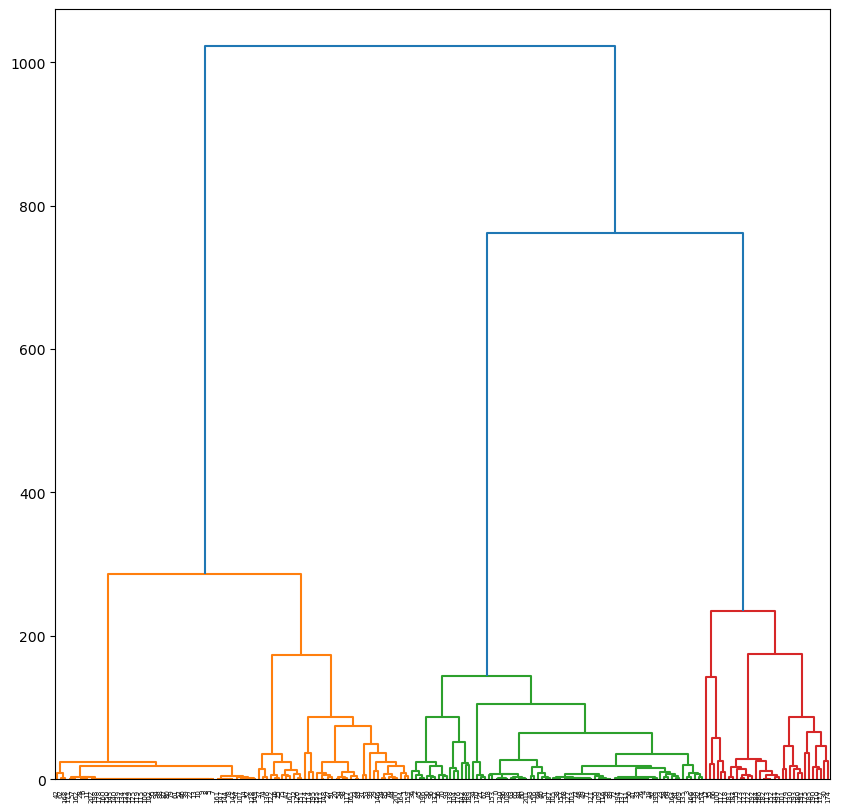

In [13]:
hr_df = df_sub[cl_c].copy()
#hr_df = (hr_df-hr_df.min())/(hr_df.max()-hr_df.min())
fig_dendo = plt.figure(figsize=(10,10))
ax_dendo = fig_dendo.add_subplot(111)
linkage_data = linkage(hr_df, method='ward', metric='euclidean')
dendrogram(linkage_data)
plt.show()

In [14]:
clust_df = df_sub[cl_c].copy().dropna()
hierarchical_cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(clust_df).round(0)
df_sub["Cluster"] = list(map(str, labels))

sumdf = df_sub[prop_c].groupby('Cluster').describe(percentiles = [0.50])
# with pd.option_context("display.max_columns", None):
#     display(sumdf)
    
outdf = os.path.join(dat_dir, 'BOSS_clust.csv')
df_sub.to_csv(outdf)

gdf_sub = gdf.query(que)
gdf_sub = gdf_sub.dropna(subset = cl_c)
gdf_sub["Cluster"] = list(map(str, labels))
boss_out = os.path.join(cwd, 'data\\BOSS\\Cleaned\\BOSS_kndavi.shp')
gdf_sub.to_file(boss_out)

In [15]:
df_duplicate = df_sub.copy()
df_duplicate['site'] = 'All sites'
frames = [df_sub,df_duplicate]
df_dup = pd.concat(frames)
df_dup = df_dup.reset_index()

In [16]:
df_dup

,index,sample,latitude,longitude,date,time_botto,site,location,visibility,image,...,kndavi_13,kndavi_14,kndavi_15,kndavi_16,kndavi_17,kndavi_18,kndavi_19,kndavi_20,kndavi_21,Cluster
0,94,C711,-31.533863,115.545007,9/04/2021,07:15:05,Two Rocks,Perth,Good,Bottom,...,0.004183,0.056047,0.054692,0.134197,0.081174,0.011756,0.090871,0.047452,0.009960,0
1,95,C723,-31.539247,115.540222,9/04/2021,07:24:53,Two Rocks,Perth,Moderate,Bottom,...,0.041983,0.237808,0.122695,0.229244,0.191897,0.192113,0.134918,0.059345,0.098193,1
2,96,C754,-31.547122,115.545767,9/04/2021,07:35:09,Two Rocks,Perth,Moderate,Bottom,...,0.146019,0.140132,0.137825,0.167583,0.181397,0.157704,0.142488,0.168327,0.062530,0
3,97,C738,-31.546480,115.555642,9/04/2021,07:44:55,Two Rocks,Perth,Good,Bottom,...,0.150842,0.203477,0.192300,0.164407,0.222480,0.119638,0.207716,0.236399,0.252178,0
4,98,C722,-31.560155,115.574777,9/04/2021,07:58:54,Two Rocks,Perth,Moderate,Bottom,...,0.135270,0.041433,0.063110,0.038567,0.172606,0.052161,0.088482,0.112326,0.124917,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,292,C1126,-29.596763,114.930835,17/04/2021,14:37:30,All sites,None,Good,Top,...,0.344087,0.237339,0.464602,0.398308,0.364385,0.345987,0.293535,0.423970,0.330143,1
402,293,C1143,-29.593177,114.907478,17/04/2021,14:50:20,All sites,None,Moderate,Top,...,0.240415,0.302181,0.239450,0.273271,0.277741,0.179004,0.188709,0.233328,0.179788,0
403,294,C1122,-29.584197,114.914183,17/04/2021,14:59:54,All sites,None,Moderate,Top,...,0.306573,0.509117,0.272637,0.311547,0.313267,0.266415,0.328255,0.323474,0.337190,1
404,295,C1154,-29.572280,114.936180,17/04/2021,15:19:36,All sites,None,Moderate,Top,...,0.622081,0.291198,0.298351,0.268048,0.223906,0.203664,0.196495,0.144713,0.210472,0


### Landsat kNDAVI response (2021)

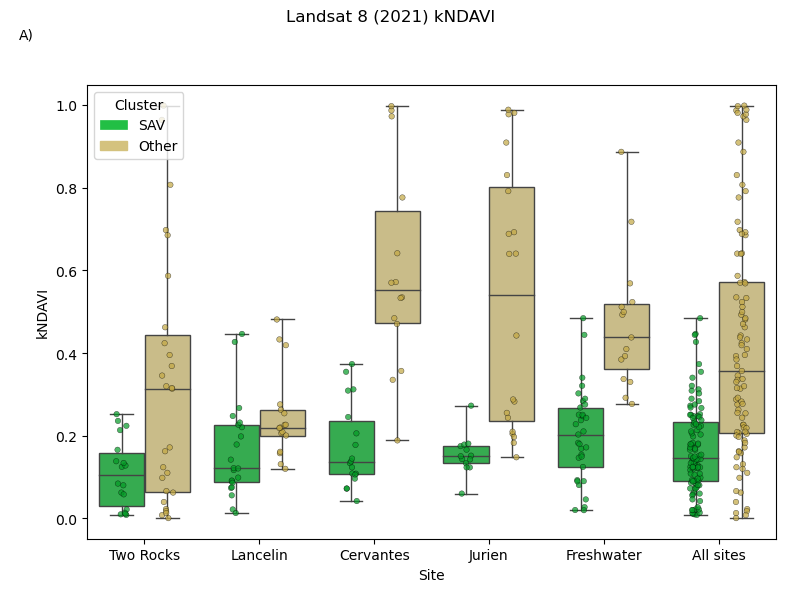

In [31]:
import matplotlib.ticker as ticker
bdf = df_dup.copy()
bdf.loc[(bdf.Cluster == "0") & (bdf.kndavi > 0.5), "kndavi"] = np.nan


fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1, 1, 1)
#ax2 = fig.add_subplot(2, 1, 2)

sns.boxplot(x = bdf['site'],
               y = bdf['kndavi'],
               whis = 15,
               dodge=True,
               showfliers = False,
               hue = bdf['Cluster'],
               palette = ['#22BF45','#D4C27E'],
               ax = ax,
               linewidth = 1)

sns.stripplot(data=bdf, x='site', y='kndavi', palette = ['#039a25','#c2a742'],
              jitter = True,edgecolor='black',marker='o', linewidth=0.3, alpha = 0.7, s = 4,
              hue= 'Cluster', dodge=True, ax=ax)

ax.legend(title='Cluster', 
          #bbox_to_anchor=(0.1243, 0.90),
          loc = 'upper left',
          labels=['SAV', 'Other'])

leg = ax.get_legend()
leg.legendHandles[0].set_color('#22BF45')
leg.legendHandles[1].set_color('#D4C27E')
#ax.xaxis.set_major_locator(ticker.NullLocator())

ax.annotate('A)',
            xy=(0.033, 0.94) ,
            xycoords = 'subfigure fraction',
            ha='center',va='center',
            fontsize=10)
            #xycoords=ax.transAxes)
    
ax.set_xlabel('Site')
ax.set_ylabel('NDAVI')
fig.suptitle('Landsat 8 (2021) kNDAVI')

ax.set_ylabel('kNDAVI')
plt.tight_layout()

In [33]:
import rpy2, os, warnings
warnings.filterwarnings('ignore')
os.environ["R_HOME"] = r"C:\Users\00097030\Anaconda3\envs\pygis\Lib\R"
%load_ext rpy2.ipython

In [34]:
%%R 
suppressMessages(pacman::p_load(raster, sp, sf, terra, tidyverse, ggplot2,
                 blockCV, caret, RStoolbox, randomForest,gridExtra,
                 pROC, dplyr, kableExtra, dismo, spsurvey, pdp))

In [35]:
%%R
poly_path = paste(getwd(), 'Data/ICoAST sites/WGS84/ICOAST_midwest.shp', sep = '/')
kndavi_path = paste(getwd(), 'Data/Bands/kndavi.tif', sep = '/')
boss_path = paste(getwd(), 'Data/Dataframes/BOSS_clust.csv', sep = '/')


aoi_r = shapefile(poly_path)
aoi_v = vect(poly_path)
poly_sf = st_as_sf(aoi_r)
boss_sf = read.csv(boss_path) %>%
          sf::st_as_sf(wkt = 'geometry', crs=4326)

In [36]:
%%R

kndavi = rast(kndavi_path) %>%
         terra::crop(aoi_v, mask = TRUE) 
                     
gc()

          used  (Mb) gc trigger  (Mb)   limit (Mb) max used  (Mb)
Ncells 4851806 259.2    7752688 414.1 2.670300e+03  7752688 414.1
Vcells 6799680  51.9   21990234 167.8 8.796093e+12 11730239  89.5


The best folds was in iteration 85:
  train_0 train_1 test_0 test_1
1      82      75     28     18
2      91      79     19     14
3      87      80     23     13
4      86      67     24     26
5      94      71     16     22


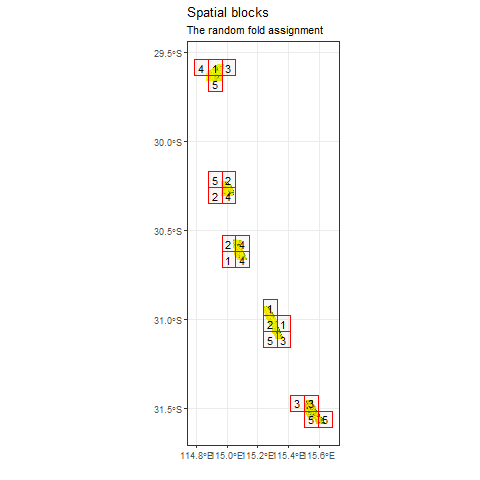

In [37]:
%%R
sb1 = spatialBlock(speciesData = boss_sf,
                   species = "Cluster",
                   rasterLayer = raster(kndavi),
                   theRange = 10000,
                   k = 5,
                   selection = "random",
                   iteration = 100,
                   numLimit = NULL,
                   biomod2Format = TRUE,
                   xOffset = 0.3,
                   progress = FALSE,
                   seed = 1,
                   yOffset = 0)

In [38]:
%%R
################################# model data frame ################################
###################################################################################
set.seed(8)
mod_df = as_Spatial(boss_sf) %>%
          data.frame() %>%
          add_column(Block = sb1$foldID) %>%
          add_column(Fold = createFolds(boss_sf$sample , k = 5, list = FALSE, returnTrain = FALSE)) %>%
          dplyr::mutate(class_int = ifelse(Class == 'SAV',1,0)) %>%
          dplyr::mutate(class_int = as.factor(class_int)) %>%
          #dplyr::mutate(Cluster = as.factor(Cluster)) %>%
          drop_na(kndavi)
file_name = paste(getwd(), 'R/model_df_lidar.rds', sep = '/')

mod_df$Site_val = ifelse(mod_df$site == "Two Rocks",1,
                  ifelse(mod_df$site == "Lancelin",2,
                  ifelse(mod_df$site == "Cervantes",3,
                  ifelse(mod_df$site == "Jurien",4,5
                  ))))

In [39]:
%%R

oob = NULL
test_err = NULL
kapp_train = NULL
kapp_test = NULL
i = 1
for(i in 1:5){
  #tryCatch({
    #print(i)
    train = subset(mod_df, mod_df$Fold != (i))
    fac_train = factor(train$Cluster)
    train$Cluster = fac_train
    test = subset(mod_df, mod_df$Fold == (i))
    fac_test = factor(test$Cluster)
    test$Cluster =  fac_test
    test = rbind(train[1, ] , test)
    test = test[-1,]
    
    rf_s = randomForest(Cluster ~  kndavi,
                        data = train,
                        na.action=na.omit,
                        ntree = 1000,
                        maxnodes = 4,
                        importance=TRUE, 
                        proximity=FALSE,
                        xtest = data.frame(test$kndavi
                                           ), 
                        ytest = test$Cluster,
                        keep.forest = TRUE)
    # file_name = paste(getwd(), paste0('R/Fold_Bands_',as.character(i),'.rds'), sep = '/')
    # saveRDS(rf_s, file_name)
    
    train_pred = predict(rf_s, train)
    conf_train = confusionMatrix(train_pred, train$Cluster)
    
    test_pred = predict(rf_s, test)
    conf_test = confusionMatrix(test_pred, test$Cluster)
    
    kapp_train[i] = conf_train$overall[1]
    oob[i] = mean(rf_s$err.rate[,1])
    
    kapp_test[i] = conf_test$overall[1]
    test_err[i] = mean(rf_s$test$err.rate[,1])

}

### Cross-validation

In [40]:
%%R
################################# error table ####################################
###################################################################################
tab = t(data.frame(oob,kapp_train, test_err, kapp_test))
mean_st = (as.numeric(rowMeans(tab)))
row.names(tab) = c('OOB error', 'Kappa (training)', 'Test error', 'Kappa (testing)')
colnames(tab) = c('Fold-1', 'Fold-2', 'Fold-3','Fold-4', 'Fold-5')
tab_df = tibble::rownames_to_column(as.data.frame(tab), "Statistic")
tab_df$Mean = mean_st
file_name = paste(getwd(), 'Data/Dataframes/kndavi.csv', sep = '/')
write.csv(tab_df, file_name, row.names=FALSE, quote=FALSE) 
tab_df

         Statistic    Fold-1    Fold-2    Fold-3    Fold-4    Fold-5      Mean
1        OOB error 0.3154685 0.2943274 0.2659463 0.2749475 0.2941725 0.2889724
2 Kappa (training) 0.7256098 0.7300613 0.7604790 0.7666667 0.7440476 0.7453729
3       Test error 0.2185385 0.2251250 0.3616111 0.3019057 0.2570857 0.2728532
4  Kappa (testing) 0.7948718 0.7750000 0.6388889 0.6981132 0.7428571 0.7299462


### Partial response

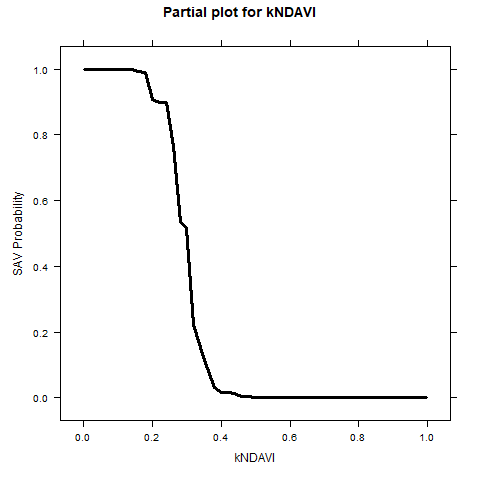

In [26]:
%%R
xlab = 'kNDAVI'
xvar = 'kndavi'
prob_lab =  'SAV Probability'
zlab = 'SAV'
rf_pred = randomForest(as.factor(Cluster) ~ kndavi,
                      data = mod_df,
                      na.action=na.omit,
                      ntree = 1000,
                      maxnodes = 2)
rf_pred %>% 
partial(pred.var = c(xvar), type = 'classification', which.class = 1, prob = TRUE) %>%
plotPartial(smooth = FALSE,
            main = paste('Partial plot for', xlab),
            lwd = 3, 
            ylab = prob_lab,
            xlab = xlab)

### threshhold 

In [36]:
year = str(21)
kndavi_out = os.path.join(dat_dir)
with rasterio.open(os.path.join(kndavi_out, 'kndavi_'+year+'.tif')) as src:    
    # Read as numpy array
    array = src.read()
    profile = src.profile

    # Reclassify
    array[np.where(array > 0.3)] = 2 
    array[np.where(array <= 0.3)] = 1
    # and so on ...  

with rasterio.open(os.path.join(kndavi_out, 'reclass//reclass_'+year+'.tif'), 'w', **profile) as dst:
    # Write to disk
    dst.write(array)

## kndavi values

In [8]:
kndavi_13 = rasterio.open(dat_dir + '\\kndavi_13.tif')
kndavi_14 = rasterio.open(dat_dir + '\\kndavi_14.tif')
kndavi_15 = rasterio.open(dat_dir + '\\kndavi_15.tif')
kndavi_16 = rasterio.open(dat_dir + '\\kndavi_16.tif')
kndavi_17 = rasterio.open(dat_dir + '\\kndavi_17.tif')
kndavi_18 = rasterio.open(dat_dir + '\\kndavi_18.tif')
kndavi_19 = rasterio.open(dat_dir + '\\kndavi_19.tif')
kndavi_20 = rasterio.open(dat_dir + '\\kndavi_20.tif')
kndavi_21 = rasterio.open(dat_dir + '\\kndavi_21.tif')
gdf['kndavi_13'] = [x[0] for x in kndavi_13.sample(coord_list)]
gdf['kndavi_14'] = [x[0] for x in kndavi_14.sample(coord_list)]
gdf['kndavi_15'] = [x[0] for x in kndavi_15.sample(coord_list)]
gdf['kndavi_16'] = [x[0] for x in kndavi_16.sample(coord_list)]
gdf['kndavi_17'] = [x[0] for x in kndavi_17.sample(coord_list)]
gdf['kndavi_18'] = [x[0] for x in kndavi_18.sample(coord_list)]
gdf['kndavi_19'] = [x[0] for x in kndavi_19.sample(coord_list)]
gdf['kndavi_20'] = [x[0] for x in kndavi_20.sample(coord_list)]
gdf['kndavi_21'] = [x[0] for x in kndavi_21.sample(coord_list)]

In [36]:
kn_melt = pd.melt(gdf, id_vars='site', value_vars=['kndavi_13', 'kndavi_14', 
                                                   'kndavi_15', 'kndavi_16',
                                                   'kndavi_17', 'kndavi_18',
                                                   'kndavi_19', 'kndavi_20', 'kndavi_21'])
que = 'site == "Cervantes" or site =="Freshwater" or site =="Jurien" or site =="Lancelin" or site =="Two Rocks"'
kn_melt = kn_melt.query(que)
kn_melt

,site,variable,value
94,Two Rocks,kndavi_13,0.004183
95,Two Rocks,kndavi_13,0.041983
96,Two Rocks,kndavi_13,0.146019
97,Two Rocks,kndavi_13,0.150842
98,Two Rocks,kndavi_13,0.135270
...,...,...,...
3556,Freshwater,kndavi_21,0.330143
3557,Freshwater,kndavi_21,0.179788
3558,Freshwater,kndavi_21,0.337190
3559,Freshwater,kndavi_21,0.210472


In [44]:
viridis = mpl.colormaps['viridis'].resampled(256)
newcolors = viridis(np.linspace(0, 1, 9))
newcolors

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.278826, 0.17549 , 0.483397, 1.      ],
       [0.229739, 0.322361, 0.545706, 1.      ],
       [0.172719, 0.448791, 0.557885, 1.      ],
       [0.127568, 0.566949, 0.550556, 1.      ],
       [0.157851, 0.683765, 0.501686, 1.      ],
       [0.369214, 0.788888, 0.382914, 1.      ],
       [0.678489, 0.863742, 0.189503, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ]])

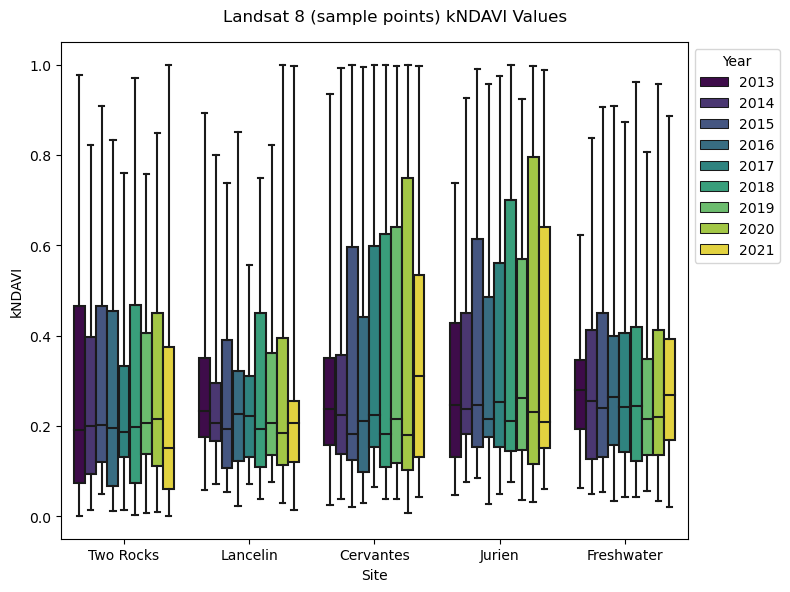

In [63]:
import matplotlib.ticker as ticker
bdf = kn_melt.copy()
#bdf.loc[(bdf.Cluster == "0") & (bdf.kndavi > 0.5), "kndavi"] = np.nan


fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1, 1, 1)
#ax2 = fig.add_subplot(2, 1, 2)
colors = [(0, 0, 0), (1, 0, 0)]
cm = LinearSegmentedColormap.from_list(
        "Custom", newcolors, N=9)
sns.boxplot(x = bdf['site'],
               y = bdf['value'],
               whis = 15,
               dodge=True,
               showfliers = False,
               hue = bdf['variable'],
               palette = newcolors,
               ax = ax)
               #linewidth = 1)

# sns.stripplot(data=bdf, x='site', y='kndavi_14', palette = ['#039a25','#c2a742'],
#               jitter = True,hue= 'Cluster',edgecolor='black',marker='o', linewidth=0.3, alpha = 0.7, s = 4, dodge=True, ax=ax)


# ax.legend(title='Year', 
#           #bbox_to_anchor=(0.1243, 0.90),
#           loc = 'upper left',
#           labels=['2013', '2014', '2015',
#                   '2016', '2017', '2018',
#                   '2019', '2020', '2021'])

# leg = ax.get_legend()
# for line in leg.get_lines():
#     line.set_linewidth(2.0)
# leg.legendHandles[0].set_color(newcolors[0])
# leg.legendHandles[1].set_color(newcolors[1])
# leg.legendHandles[2].set_color(newcolors[2])
# leg.legendHandles[3].set_color(newcolors[3])
# leg.legendHandles[4].set_color(newcolors[4])
# leg.legendHandles[5].set_color(newcolors[5])
# leg.legendHandles[6].set_color(newcolors[6])
# leg.legendHandles[7].set_color(newcolors[7])
# leg.legendHandles[8].set_color(newcolors[8])
# for line in leg.get_lines():
#     line.set_linewidth(2.0)


#ax.xaxis.set_major_locator(ticker.NullLocator())

# ax.annotate('A)',
#             xy=(0.033, 0.94) ,
#             xycoords = 'subfigure fraction',
#             ha='center',va='center',
#             fontsize=10)
            #xycoords=ax.transAxes)
    
ax.set_xlabel('Site')
legend_handles, _= ax.get_legend_handles_labels()
ax.legend(legend_handles, ['2013', '2014', '2015',
                          '2016', '2017', '2018',
                          '2019', '2020', '2021'], 
          title='Year')
#ax.set_ylabel('NDAVI')
fig.suptitle('Landsat 8 (sample points) kNDAVI Values')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_ylabel('kNDAVI')

plt.tight_layout()

## Area

In [37]:
import glob
cwd = os.getcwd()
pred_dir = os.path.join(cwd, 'Data\\Bands\\reclass')
sav_list = glob.glob(pred_dir+'\\reclass*.tif')
sites = ['Two_rocks', 'Lancelin', 'Cervantes', 'Jurien', 'Cliff_head']

In [39]:
sav_list 

['C:\\Users\\00097030\\Git\\Landsat-SAV\\Data\\Bands\\reclass\\reclass_13.tif',
 'C:\\Users\\00097030\\Git\\Landsat-SAV\\Data\\Bands\\reclass\\reclass_14.tif',
 'C:\\Users\\00097030\\Git\\Landsat-SAV\\Data\\Bands\\reclass\\reclass_15.tif',
 'C:\\Users\\00097030\\Git\\Landsat-SAV\\Data\\Bands\\reclass\\reclass_16.tif',
 'C:\\Users\\00097030\\Git\\Landsat-SAV\\Data\\Bands\\reclass\\reclass_17.tif',
 'C:\\Users\\00097030\\Git\\Landsat-SAV\\Data\\Bands\\reclass\\reclass_18.tif',
 'C:\\Users\\00097030\\Git\\Landsat-SAV\\Data\\Bands\\reclass\\reclass_19.tif',
 'C:\\Users\\00097030\\Git\\Landsat-SAV\\Data\\Bands\\reclass\\reclass_20.tif',
 'C:\\Users\\00097030\\Git\\Landsat-SAV\\Data\\Bands\\reclass\\reclass_21.tif']

In [60]:
site_list = []
year_list = []
area_list = []
perc_list = []
for shp in sites:
    bound_p = os.path.join(cwd,'data\\ICoAST sites\\Sites')
    shp_file = glob.glob(bound_p+'\\'+shp+'*.shp')
    ex = gpd.read_file(*shp_file)
    ext = ex.explode().geometry
    for tif in sav_list:
        #nm = '_'.join(tif.split('\\')[-1].split('.')[0].split('_')[1:])
        nm = str(20)+'_'.join(tif.split('\\')[-1].split('.')[0].split('_')[-1:])
        class_ras = rasterio.open(tif)
        cl_crop, cl_transform = mask(class_ras, ext, crop = True, nodata=255, filled=False, all_touched=False)
        sav_pix =  ma.masked_not_equal(cl_crop, 1) 
        area = ma.MaskedArray.count(sav_pix, keepdims = False)
        count = ma.MaskedArray.count(cl_crop, keepdims = False)
        m2 = area*(28.49*28.49)
        ha = m2 / 10000
        km2 = m2*0.000001
        perc = area/count * 100
        
        if (shp == 'Cliff_head'):
            shp = 'Freshwater'
            
        site_list.append(shp)
        year_list.append(nm)
        area_list.append(km2)
        perc_list.append(perc)

areadf = pd.DataFrame(list(zip(site_list, year_list, area_list, perc_list)), columns = ['Site', 'Year', 'Area SAV', 'Percentage SAV'])

In [61]:
areadf

,Site,Year,Area SAV,Percentage SAV
0,Two_rocks,2013,70.877530,64.517607
1,Two_rocks,2014,70.219257,63.918402
2,Two_rocks,2015,70.430294,64.110502
3,Two_rocks,2016,70.188413,63.890326
4,Two_rocks,2017,72.808517,66.275324
5,Two_rocks,2018,72.339366,65.848270
6,Two_rocks,2019,70.638896,64.300386
7,Two_rocks,2020,70.426236,64.106808
8,Two_rocks,2021,71.451388,65.039972
9,Lancelin,2013,77.310906,70.010584


### plot

<Figure size 1200x1200 with 0 Axes>

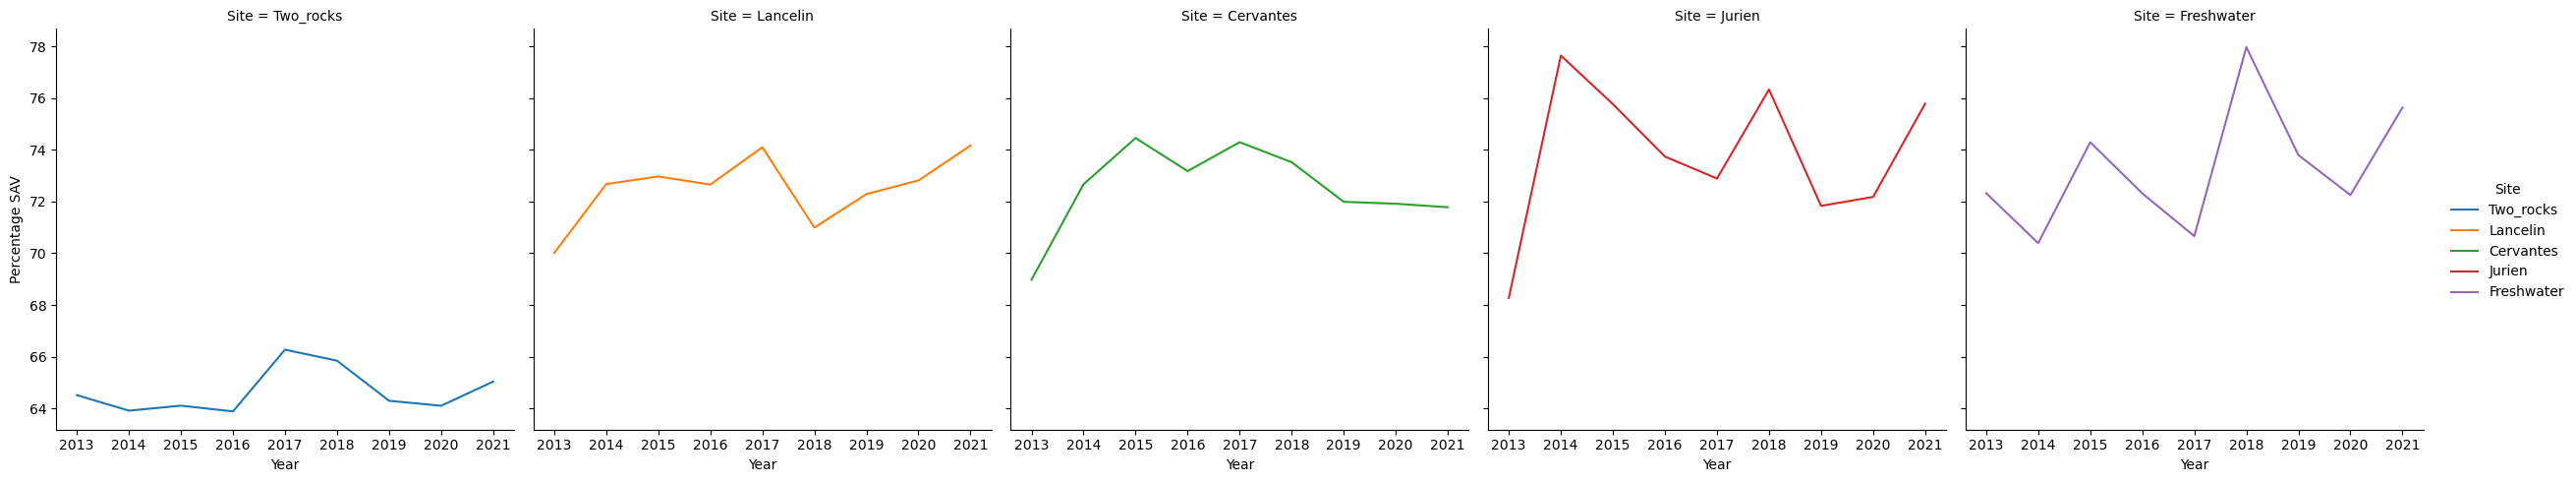

In [70]:
#sns.relplot(data=areadf, x="Year", y="Area SAV", hue="Site")
fig = plt.figure(figsize = (12,12))
ax = sns.relplot(data=areadf,
            x="Year",
            y="Percentage SAV",
            hue="Site",
            col = 'Site',
            #row = 'Site',
            kind="line")
#, col="time", row="sex")

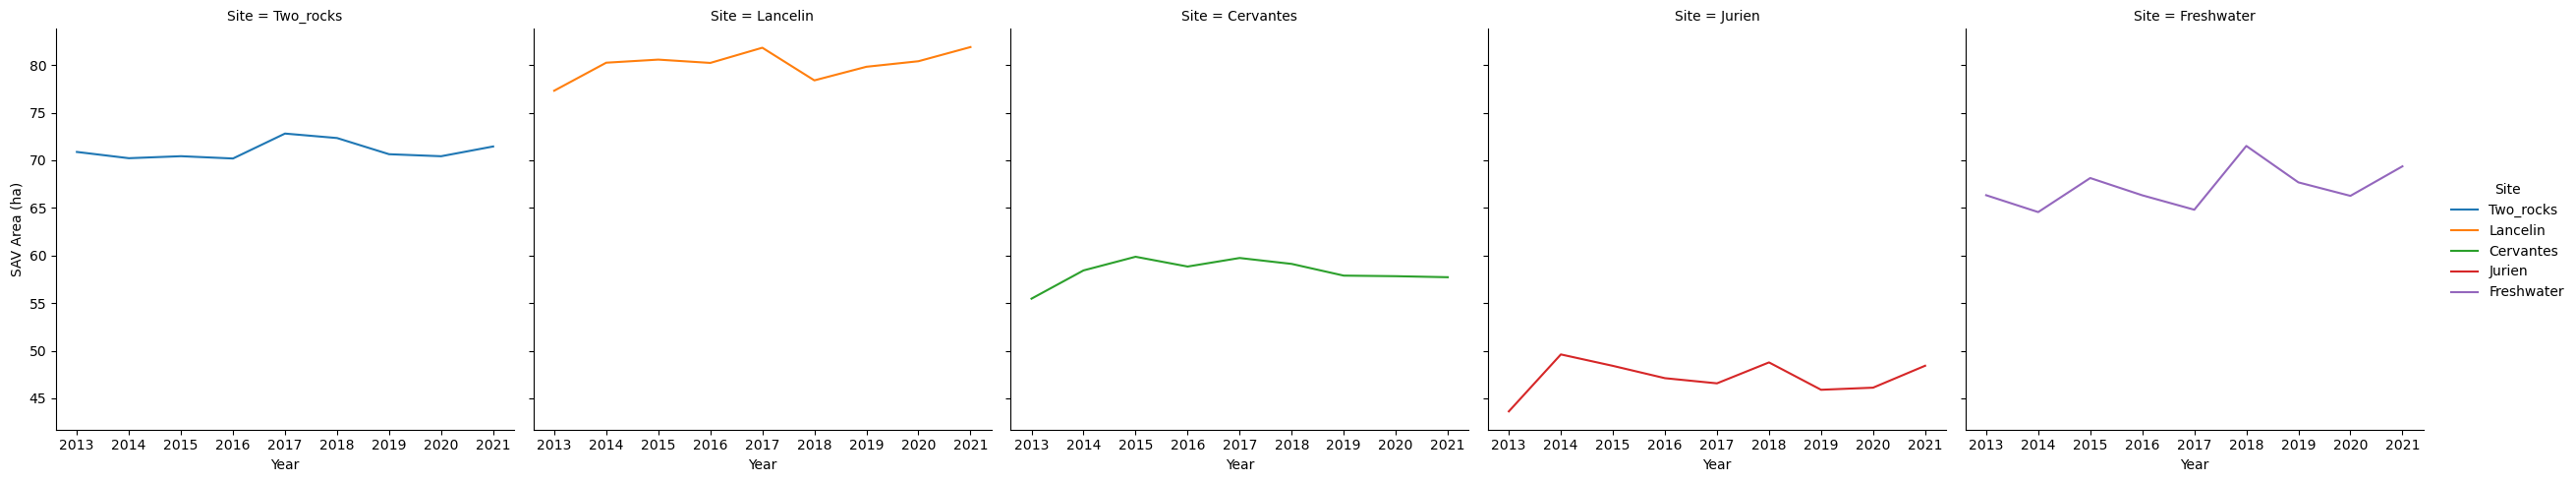

In [71]:
ax = sns.relplot(data=areadf,
            x="Year",
            y="Area SAV",
            hue="Site",
            col = 'Site',
            kind="line")
ax.set(ylabel='SAV Area (ha)')

<AxesSubplot: xlabel='Year', ylabel='Percentage SAV'>

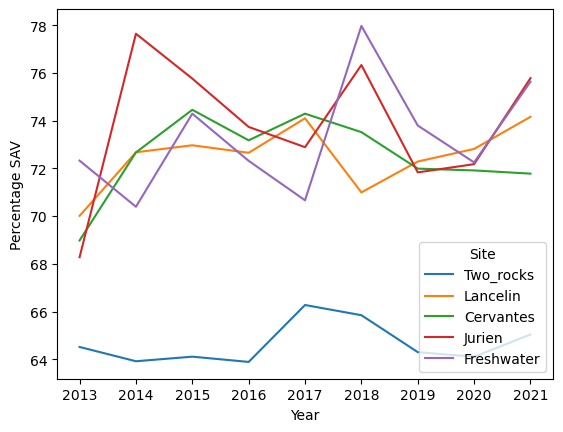

In [64]:
sns.lineplot(data=areadf,
            x="Year",
            y="Percentage SAV",
            hue="Site")

[Text(0, 0.5, 'SAV Area (ha)')]

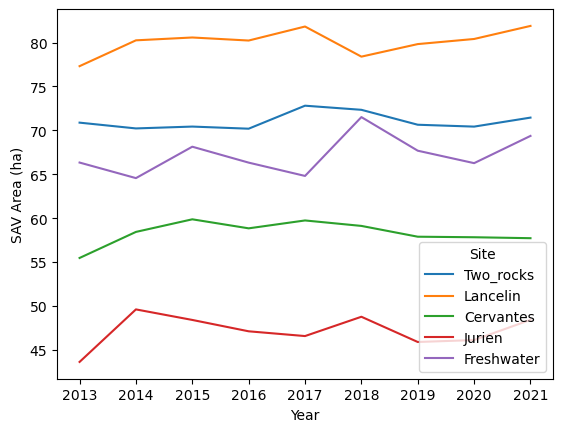

In [65]:
ax = sns.lineplot(data=areadf,
            x="Year",
            y="Area SAV",
            hue="Site")
ax.set(ylabel='SAV Area (ha)')

In [ ]:
# piv_area = areadf.pivot(index='Model',
#                         columns='Site',
#                         values='Area SAV').reset_index()

# piv_area.rename(columns={'Model': 'Model',
#                          'Cervantes': 'Cervantes',
#                          'Cliff_head': 'Freshwater',
#                          'Jurien': 'Jurien',
#                          'Lancelin': 'Lancelin',
#                          'Two_rocks': 'Two Rocks'}, inplace=True)

# neworder = ['Model','Two Rocks','Lancelin','Cervantes','Jurien', 'Freshwater']
# piv_area = piv_area.reindex(columns=neworder)
# col_list = list(piv_area)
# col_list.remove('Model')
# piv_area['Total'] = piv_area[col_list].sum(axis=1)
# piv_area = piv_area.round(decimals=1)
# piv_area[['Two Rocks','Lancelin','Cervantes','Jurien', 'Freshwater', 'Total']] = piv_area[['Two Rocks','Lancelin','Cervantes','Jurien', 'Freshwater', 'Total']].astype(float)
# piv_area[['Two Rocks','Lancelin','Cervantes','Jurien', 'Freshwater']] =  piv_area[['Two Rocks','Lancelin','Cervantes','Jurien', 'Freshwater']].astype(str) + ' ( %)'
# piv_area['Total'] =  piv_area['Total'].astype(str) + ' ( %)'
# dat_dir = os.path.join(cwd, 'data\\Dataframes\\Area')
# outdf = os.path.join(dat_dir, 'SAV_area.csv')
# piv_area = piv_area.astype(str)
# piv_area.to_csv(outdf, index = False)

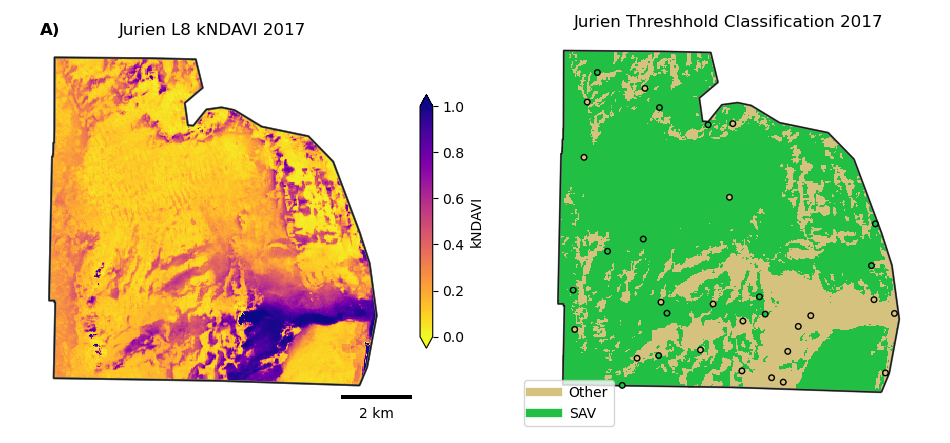

In [81]:
year = str(17)
boss_out = os.path.join(cwd, 'data\\BOSS\\Cleaned\\BOSS_kndavi.shp')
boss = gpd.read_file(boss_out)

cmap = plt.cm.get_cmap("Greys_r").copy()
cmap.set_bad('red',.1)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)



ex_p = os.path.join(cwd,'data\\ICoAST sites\\Sites\\Jurien.shp')
ex = gpd.read_file(ex_p)
ext = ex.explode().geometry

bgeom = ex.total_bounds
plt.rcParams['figure.figsize'] = [9, 9]
x, y, arrow_length = 0.01, 0.99, 0.1
hfont = {'fontname':'Rockwell'}


dummy_path = os.path.join(cwd,'Data\\ICoAST sites\\WGS84\\ICOAST_midwest.shp')
dummy = gpd.read_file(dummy_path)
dummy['colramp_prob'] = np.linspace(0, 1,len(dummy))

##############################################
##############composite#####################
co_dir = os.path.join(cwd, 'Data\\bands\\L8_'+year+'.tif')
co_ras = rasterio.open(co_dir)
rgb_crop, rgb_transform = rasterio.mask.mask(co_ras, ext, crop = True, filled=True)
rgb_crop = np.nan_to_num(np.clip(rgb_crop[4::-1],0,0.06), nan = 0)
rgb_crop[rgb_crop==0] = 255

co_dir = os.path.join(cwd, 'Data\\bands\\kndavi_'+year+'.tif')
co_ras = rasterio.open(co_dir)

rgb_crop, rgb_transform = mask(co_ras, ext, crop = True)
#rgb_crop = np.nan_to_num(np.clip(rgb_crop,0.01,1), nan = 0)
rgb_crop[rgb_crop==0] = np.nan

boundgdf_plot = ex.plot(facecolor='none',
                              alpha = 1,
                              edgecolor='grey',
                              ax = ax,
                              lw=1.5,
                              legend=True)

boundgdf_plot.annotate('Jurien L8 kNDAVI 20'+year,
                        xy=(0.5, 0.97) ,
                        ha='center',va='center',
                        fontsize=12,
                        xycoords=boundgdf_plot.transAxes)

boundgdf_plot.annotate('A)',
                        xy=(0.1, 0.97),
                        weight='bold',
                        ha='center',va='center',
                        fontsize=12,
                        xycoords=boundgdf_plot.transAxes)

boundgdf_plot.add_artist(ScaleBar(111000,frameon = False, location='lower right'))

# rplot.show(rgb_crop[1:4,:,:],
#            #title='Composite',
#            #interpolation = 'nearest',
#            adjust = 'True',
#            with_bounds = True,
#            cmap = cmap,
#            ax = boundgdf_plot,
#            transform=rgb_transform)

dummy.plot(facecolor='none',
           alpha = 1,
           edgecolor='grey', 
           column='colramp_prob', 
           cmap = 'plasma_r',
           ax = boundgdf_plot, 
           lw=1.5,
           legend=True,
           legend_kwds={'label': 'kNDAVI',
                    'fraction' : 0.03 ,
                    'pad' : 0.01 ,
                    'orientation' : 'vertical',
                    'extend' : 'both'})


rplot.show(rgb_crop[0,:,:],
           #title='Composite',
           interpolation = 'nearest',
           with_bounds = True,
           adjust = False,
           #cmap = cmap,
           cmap= 'plasma_r', 
           ax = boundgdf_plot,
           transform=rgb_transform)

boundgdf_plot.set(xlim=(bgeom[0]-0.01, bgeom[2]+0.01),
                  ylim=(bgeom[1]-0.01, bgeom[3]+0.01));

# wa.plot(ax=boundgdf_plot, 
#             facecolor='grey', 
#             edgecolor= 'black', 
#             lw=1).axis('off'); 

ex.plot(ax=boundgdf_plot, 
            facecolor='none', 
            edgecolor=(0,0,0,0.8), 
            lw=1).axis('off'); 

# inset_ax = inset_axes(boundgdf_plot,
#                     width = '20%', 
#                     height = '20%',
#                     loc ='upper right')

# inset_ax.get_xaxis().set_ticks([])
# inset_ax.get_yaxis().set_ticks([])

# wa.plot(ax=inset_ax, 
#             facecolor='grey', 
#             edgecolor= 'black', 
#             lw=1)

# ex.plot(ax=inset_ax, 
#         facecolor='none',
#         alpha = 1,
#         edgecolor='red',  
#         lw=5).axis('off');

###########################################

cl_dir = os.path.join(cwd, 'Data\\bands\\reclass\\reclass_'+year+'.tif')

clus1_ras = rasterio.open(cl_dir)
cl_crop, cl_transform = mask(clus1_ras, ext, crop = True, nodata=255, filled=False)
cl_flip = np.flip(np.flip(cl_crop),2)


cmapc = ListedColormap(['#22BF45' ,'#D4C27E']) 
custom_lines = lines = [Line2D([0], [0], color = '#D4C27E', lw=6),
                        Line2D([0], [0], color = '#22BF45', lw=6)]

leg_names = ['Other', 'SAV']


boundgdf_plot = ex.plot(facecolor='none',
                              alpha = 1,
                              edgecolor='grey',
                              ax = ax2,
                              lw=1.5,
                              legend=True)


boundgdf_plot.legend(custom_lines, leg_names, title = '', loc = 'lower left')
boundgdf_plot.annotate('Jurien Threshhold Classification 20'+year,
                        xy=(0.5, 0.97) ,
                        ha='center',va='center',
                        fontsize=12,
                        xycoords=boundgdf_plot.transAxes)

# wa.plot(ax=boundgdf_plot, 
#             facecolor='grey', 
#             edgecolor= 'black', 
#             lw=1).axis('off'); 

ex.plot(ax=boundgdf_plot, 
            facecolor='none', 
            edgecolor=(0,0,0,0.8), 
            lw=1).axis('off'); 

boss['pcolor'] = np.where(boss['Cluster']=='0', '#22BF45', '#D4C27E')

boss.plot(ax=boundgdf_plot, 
         #facecolor='grey',
         markersize = 16,
         color=boss['pcolor'],
         edgecolor= 'black', 
         lw=1).axis('off');

rplot.show(cl_crop,
           transform=cl_transform,
           interpolation =  'nearest',
           with_bounds = True,
           adjust = False,
           cmap= cmapc, 
           ax = boundgdf_plot)


rplot.show(cl_crop,
           transform=cl_transform,
           interpolation =  'nearest',
           with_bounds = True,
           adjust = False,
           alpha = 0,
           cmap= cmapc, 
           ax = ax)


boundgdf_plot.set(xlim=(bgeom[0]-0.01, bgeom[2]+0.01),
                  ylim=(bgeom[1]-0.01, bgeom[3]+0.01));


del clus1_ras, cl_crop, cl_transform, cl_flip;


#plt.savefig(os.path.join(cwd,'images\\Model Vis\\TR_'+out_file), bbox_inches='tight');

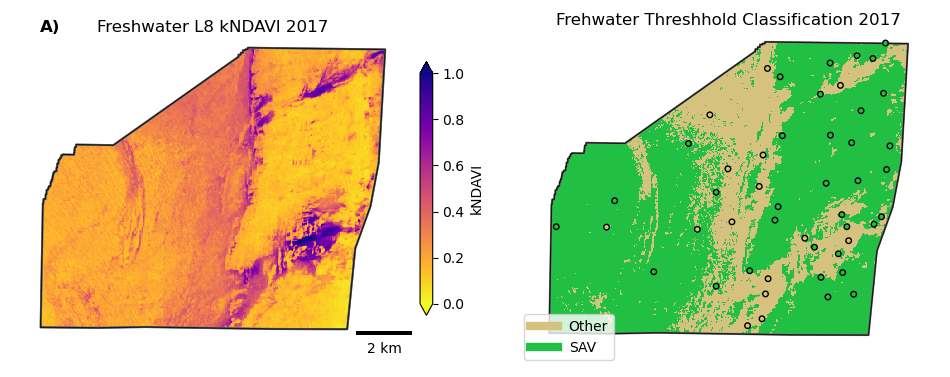

In [84]:
year = str(17)
boss_out = os.path.join(cwd, 'data\\BOSS\\Cleaned\\BOSS_kndavi.shp')
boss = gpd.read_file(boss_out)

cmap = plt.cm.get_cmap("Greys_r").copy()
cmap.set_bad('red',.1)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)



ex_p = os.path.join(cwd,'data\\ICoAST sites\\Sites\\Cliff_head.shp')
ex = gpd.read_file(ex_p)
ext = ex.explode().geometry

bgeom = ex.total_bounds
plt.rcParams['figure.figsize'] = [9, 9]
x, y, arrow_length = 0.01, 0.99, 0.1
hfont = {'fontname':'Rockwell'}


dummy_path = os.path.join(cwd,'Data\\ICoAST sites\\WGS84\\ICOAST_midwest.shp')
dummy = gpd.read_file(dummy_path)
dummy['colramp_prob'] = np.linspace(0, 1,len(dummy))

##############################################
##############composite#####################
co_dir = os.path.join(cwd, 'Data\\bands\\L8_'+year+'.tif')
co_ras = rasterio.open(co_dir)
rgb_crop, rgb_transform = rasterio.mask.mask(co_ras, ext, crop = True, filled=True)
rgb_crop = np.nan_to_num(np.clip(rgb_crop[4::-1],0,0.06), nan = 0)
rgb_crop[rgb_crop==0] = 255

co_dir = os.path.join(cwd, 'Data\\bands\\kndavi_'+year+'.tif')
co_ras = rasterio.open(co_dir)

rgb_crop, rgb_transform = mask(co_ras, ext, crop = True)
#rgb_crop = np.nan_to_num(np.clip(rgb_crop,0.01,1), nan = 0)
rgb_crop[rgb_crop==0] = np.nan

boundgdf_plot = ex.plot(facecolor='none',
                              alpha = 1,
                              edgecolor='grey',
                              ax = ax,
                              lw=1.5,
                              legend=True)

boundgdf_plot.annotate('Freshwater L8 kNDAVI 20'+year,
                        xy=(0.5, 0.97) ,
                        ha='center',va='center',
                        fontsize=12,
                        xycoords=boundgdf_plot.transAxes)

boundgdf_plot.annotate('A)',
                        xy=(0.1, 0.97),
                        weight='bold',
                        ha='center',va='center',
                        fontsize=12,
                        xycoords=boundgdf_plot.transAxes)

boundgdf_plot.add_artist(ScaleBar(111000,frameon = False, location='lower right'))

# rplot.show(rgb_crop[1:4,:,:],
#            #title='Composite',
#            #interpolation = 'nearest',
#            adjust = 'True',
#            with_bounds = True,
#            cmap = cmap,
#            ax = boundgdf_plot,
#            transform=rgb_transform)

dummy.plot(facecolor='none',
           alpha = 1,
           edgecolor='grey', 
           column='colramp_prob', 
           cmap = 'plasma_r',
           ax = boundgdf_plot, 
           lw=1.5,
           legend=True,
           legend_kwds={'label': 'kNDAVI',
                    'fraction' : 0.03 ,
                    'pad' : 0.01 ,
                    'orientation' : 'vertical',
                    'extend' : 'both'})


rplot.show(rgb_crop[0,:,:],
           #title='Composite',
           interpolation = 'nearest',
           with_bounds = True,
           adjust = False,
           #cmap = cmap,
           cmap= 'plasma_r', 
           ax = boundgdf_plot,
           transform=rgb_transform)

boundgdf_plot.set(xlim=(bgeom[0]-0.01, bgeom[2]+0.01),
                  ylim=(bgeom[1]-0.01, bgeom[3]+0.01));

# wa.plot(ax=boundgdf_plot, 
#             facecolor='grey', 
#             edgecolor= 'black', 
#             lw=1).axis('off'); 

ex.plot(ax=boundgdf_plot, 
            facecolor='none', 
            edgecolor=(0,0,0,0.8), 
            lw=1).axis('off'); 

# inset_ax = inset_axes(boundgdf_plot,
#                     width = '20%', 
#                     height = '20%',
#                     loc ='upper right')

# inset_ax.get_xaxis().set_ticks([])
# inset_ax.get_yaxis().set_ticks([])

# wa.plot(ax=inset_ax, 
#             facecolor='grey', 
#             edgecolor= 'black', 
#             lw=1)

# ex.plot(ax=inset_ax, 
#         facecolor='none',
#         alpha = 1,
#         edgecolor='red',  
#         lw=5).axis('off');

###########################################

cl_dir = os.path.join(cwd, 'Data\\bands\\reclass\\reclass_'+year+'.tif')

clus1_ras = rasterio.open(cl_dir)
cl_crop, cl_transform = mask(clus1_ras, ext, crop = True, nodata=255, filled=False)
cl_flip = np.flip(np.flip(cl_crop),2)


cmapc = ListedColormap(['#22BF45' ,'#D4C27E']) 
custom_lines = lines = [Line2D([0], [0], color = '#D4C27E', lw=6),
                        Line2D([0], [0], color = '#22BF45', lw=6)]

leg_names = ['Other', 'SAV']


boundgdf_plot = ex.plot(facecolor='none',
                              alpha = 1,
                              edgecolor='grey',
                              ax = ax2,
                              lw=1.5,
                              legend=True)


boundgdf_plot.legend(custom_lines, leg_names, title = '', loc = 'lower left')
boundgdf_plot.annotate('Frehwater Threshhold Classification 20'+year,
                        xy=(0.5, 0.97) ,
                        ha='center',va='center',
                        fontsize=12,
                        xycoords=boundgdf_plot.transAxes)

# wa.plot(ax=boundgdf_plot, 
#             facecolor='grey', 
#             edgecolor= 'black', 
#             lw=1).axis('off'); 

ex.plot(ax=boundgdf_plot, 
            facecolor='none', 
            edgecolor=(0,0,0,0.8), 
            lw=1).axis('off'); 

boss['pcolor'] = np.where(boss['Cluster']=='0', '#22BF45', '#D4C27E')

boss.plot(ax=boundgdf_plot, 
         #facecolor='grey',
         markersize = 16,
         color=boss['pcolor'],
         edgecolor= 'black', 
         lw=1).axis('off');

rplot.show(cl_crop,
           transform=cl_transform,
           interpolation =  'nearest',
           with_bounds = True,
           adjust = False,
           cmap= cmapc, 
           ax = boundgdf_plot)


rplot.show(cl_crop,
           transform=cl_transform,
           interpolation =  'nearest',
           with_bounds = True,
           adjust = False,
           alpha = 0,
           cmap= cmapc, 
           ax = ax)


boundgdf_plot.set(xlim=(bgeom[0]-0.01, bgeom[2]+0.01),
                  ylim=(bgeom[1]-0.01, bgeom[3]+0.01));


del clus1_ras, cl_crop, cl_transform, cl_flip;


#plt.savefig(os.path.join(cwd,'images\\Model Vis\\TR_'+out_file), bbox_inches='tight');

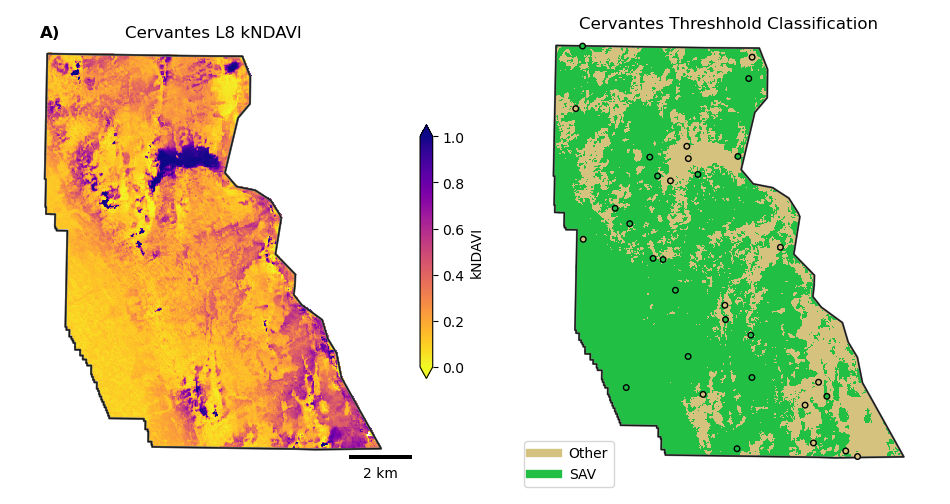

In [50]:
boss_out = os.path.join(cwd, 'data\\BOSS\\Cleaned\\BOSS_kndavi.shp')
boss = gpd.read_file(boss_out)

cmap = plt.cm.get_cmap("Greys_r").copy()
cmap.set_bad('red',.1)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)



ex_p = os.path.join(cwd,'data\\ICoAST sites\\Sites\\Cervantes.shp')
ex = gpd.read_file(ex_p)
ext = ex.explode().geometry

bgeom = ex.total_bounds
plt.rcParams['figure.figsize'] = [9, 9]
x, y, arrow_length = 0.01, 0.99, 0.1
hfont = {'fontname':'Rockwell'}


dummy_path = os.path.join(cwd,'Data\\ICoAST sites\\WGS84\\ICOAST_midwest.shp')
dummy = gpd.read_file(dummy_path)
dummy['colramp_prob'] = np.linspace(0, 1,len(dummy))

##############################################
##############composite#####################
co_dir = os.path.join(cwd, 'Data\\bands\\L8_21.tif')
co_ras = rasterio.open(co_dir)
rgb_crop, rgb_transform = rasterio.mask.mask(co_ras, ext, crop = True, filled=True)
rgb_crop = np.nan_to_num(np.clip(rgb_crop[4::-1],0,0.06), nan = 0)
rgb_crop[rgb_crop==0] = 255

co_dir = os.path.join(cwd, 'Data\\bands\\kndavi.tif')
co_ras = rasterio.open(co_dir)

rgb_crop, rgb_transform = mask(co_ras, ext, crop = True)
#rgb_crop = np.nan_to_num(np.clip(rgb_crop,0.01,1), nan = 0)
rgb_crop[rgb_crop==0] = np.nan

boundgdf_plot = ex.plot(facecolor='none',
                              alpha = 1,
                              edgecolor='grey',
                              ax = ax,
                              lw=1.5,
                              legend=True)

boundgdf_plot.annotate('Cervantes L8 kNDAVI',
                        xy=(0.5, 0.97) ,
                        ha='center',va='center',
                        fontsize=12,
                        xycoords=boundgdf_plot.transAxes)

boundgdf_plot.annotate('A)',
                        xy=(0.1, 0.97),
                        weight='bold',
                        ha='center',va='center',
                        fontsize=12,
                        xycoords=boundgdf_plot.transAxes)

boundgdf_plot.add_artist(ScaleBar(111000,frameon = False, location='lower right'))

# rplot.show(rgb_crop[1:4,:,:],
#            #title='Composite',
#            #interpolation = 'nearest',
#            adjust = 'True',
#            with_bounds = True,
#            cmap = cmap,
#            ax = boundgdf_plot,
#            transform=rgb_transform)

dummy.plot(facecolor='none',
           alpha = 1,
           edgecolor='grey', 
           column='colramp_prob', 
           cmap = 'plasma_r',
           ax = boundgdf_plot, 
           lw=1.5,
           legend=True,
           legend_kwds={'label': 'kNDAVI',
                    'fraction' : 0.03 ,
                    'pad' : 0.01 ,
                    'orientation' : 'vertical',
                    'extend' : 'both'})


rplot.show(rgb_crop[0,:,:],
           #title='Composite',
           interpolation = 'nearest',
           with_bounds = True,
           adjust = False,
           #cmap = cmap,
           cmap= 'plasma_r', 
           ax = boundgdf_plot,
           transform=rgb_transform)

boundgdf_plot.set(xlim=(bgeom[0]-0.01, bgeom[2]+0.01),
                  ylim=(bgeom[1]-0.01, bgeom[3]+0.01));

# wa.plot(ax=boundgdf_plot, 
#             facecolor='grey', 
#             edgecolor= 'black', 
#             lw=1).axis('off'); 

ex.plot(ax=boundgdf_plot, 
            facecolor='none', 
            edgecolor=(0,0,0,0.8), 
            lw=1).axis('off'); 

# inset_ax = inset_axes(boundgdf_plot,
#                     width = '20%', 
#                     height = '20%',
#                     loc ='upper right')

# inset_ax.get_xaxis().set_ticks([])
# inset_ax.get_yaxis().set_ticks([])

# wa.plot(ax=inset_ax, 
#             facecolor='grey', 
#             edgecolor= 'black', 
#             lw=1)

ex.plot(ax=inset_ax, 
        facecolor='none',
        alpha = 1,
        edgecolor='red',  
        lw=5).axis('off');

###########################################

cl_dir = os.path.join(cwd, 'Data\\bands\\reclass.tif')

clus1_ras = rasterio.open(cl_dir)
cl_crop, cl_transform = mask(clus1_ras, ext, crop = True, nodata=255, filled=False)
cl_flip = np.flip(np.flip(cl_crop),2)


cmapc = ListedColormap(['#22BF45' ,'#D4C27E']) 
custom_lines = lines = [Line2D([0], [0], color = '#D4C27E', lw=6),
                        Line2D([0], [0], color = '#22BF45', lw=6)]

leg_names = ['Other', 'SAV']


boundgdf_plot = ex.plot(facecolor='none',
                              alpha = 1,
                              edgecolor='grey',
                              ax = ax2,
                              lw=1.5,
                              legend=True)


boundgdf_plot.legend(custom_lines, leg_names, title = '', loc = 'lower left')
boundgdf_plot.annotate('Cervantes Threshhold Classification',
                        xy=(0.5, 0.97) ,
                        ha='center',va='center',
                        fontsize=12,
                        xycoords=boundgdf_plot.transAxes)

# wa.plot(ax=boundgdf_plot, 
#             facecolor='grey', 
#             edgecolor= 'black', 
#             lw=1).axis('off'); 

ex.plot(ax=boundgdf_plot, 
            facecolor='none', 
            edgecolor=(0,0,0,0.8), 
            lw=1).axis('off'); 

boss['pcolor'] = np.where(boss['Cluster']=='0', '#22BF45', '#D4C27E')

boss.plot(ax=boundgdf_plot, 
         #facecolor='grey',
         markersize = 16,
         color=boss['pcolor'],
         edgecolor= 'black', 
         lw=1).axis('off');

rplot.show(cl_crop,
           transform=cl_transform,
           interpolation =  'nearest',
           with_bounds = True,
           adjust = False,
           cmap= cmapc, 
           ax = boundgdf_plot)


rplot.show(cl_crop,
           transform=cl_transform,
           interpolation =  'nearest',
           with_bounds = True,
           adjust = False,
           alpha = 0,
           cmap= cmapc, 
           ax = ax)


boundgdf_plot.set(xlim=(bgeom[0]-0.01, bgeom[2]+0.01),
                  ylim=(bgeom[1]-0.01, bgeom[3]+0.01));


del clus1_ras, cl_crop, cl_transform, cl_flip;


#plt.savefig(os.path.join(cwd,'images\\Model Vis\\TR_'+out_file), bbox_inches='tight');